In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula import api as sm
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
# Read json file of pitcher stats into a DF.
k_df = pd.read_json('pitcher_stats.json')

In [4]:
# Salary is object data type.  Need to convert that into an integer value.
# Strip '$', get rid of commas, and convert to integer.

k_df.salary = k_df.salary.apply(lambda x: int(''.join(x.strip('$ ').split(','))) if x else None)

In [5]:
# Some players from the early 20th century got scraped by mistake.
# Get rid of any player-years that are not from 2000 or later.

k_df.drop(k_df[k_df.year < 2000].index, inplace=True)

In [6]:
# 43% of the player-years don't have salary information.
# I will drop those years, though I may want to come back to this later
# and potentially make some assumptions.  E.g. that a salary from a previous
# player-year can be extrapolated forward to another player-year without a salary record.

k_df = k_df.dropna(subset=['salary'])

In [7]:
# Since I am hypothesizing that salary follows a lognormal distribution,
# similar to the distribution of income in the general economy,
# I want to include a log_salary column.

k_df['log_salary'] = np.log(k_df.salary)

In [8]:
# Due to team changes, some team name values need to be fixed.
# E.g. FLA needs to be changed to MIA.

replacements = {
                "FLA": "MIA",
                "MON": "WSN",
                "ANA": "LAA",
                "TBD": "TBR",
                }

k_df = k_df.replace({'team': replacements})

In [13]:
# Reset index to prepare for split-apply-combine operation.

k_df = k_df.reset_index(drop=True)

In [9]:
# Group by player, and create next_year_salary column with a shift.

k_df[['next_year_salary', 'next_year_log_salary']] = k_df.groupby('player_name')[['salary', 'log_salary']].apply(lambda x: x.shift(1))

In [10]:
k_df = k_df.dropna(subset=[['next_year_salary', 'next_year_log_salary']])

In [12]:
k_df = k_df.dropna()

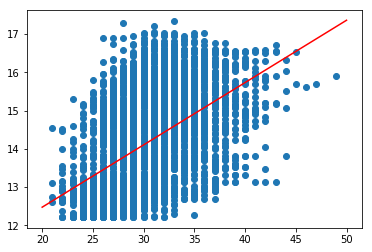

In [32]:
X = k_df.age[:, np.newaxis]
y = k_df.next_year_log_salary
lm = LinearRegression()
lm.fit(X, y)

x_plot = np.linspace(20, 50, 100)
y_plot = lm.predict(x_plot[:, np.newaxis])
plt.scatter(X, y)
plt.plot(x_plot, y_plot, color='red', );

In [16]:
lms = sm.OLS(X, y)
fit = lms.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     2127.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:21:18   Log-Likelihood:                -35576.
No. Observations:                4037   AIC:                         7.115e+04
Df Residuals:                    4036   BIC:                         7.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
next_year_salary     0.0002   5.12e-06     46.122      0.000       0.000       0.000
==============================================================================
Omnibus:                     2046.018   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12512.211
Skew:                          -2.406   Prob(JB):                         0.00
Kurtosis:                      10.158   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""